In [9]:
from matplotlib import pyplot as plt
import matplotlib
import numpy as np

from matplotlib.pyplot import figure

def group_data(lines: [str]) -> [str]:
    result = {}

    for line in lines:
        parts = line.split(',')
        if parts[0] in result:
            result[parts[0]].append((int(parts[1]), int(parts[2])))
        else:
            result[parts[0]] = [(int(parts[1]), int(parts[2]))]

    return result

geth_evm_go_benchmarks = None
with open("benchmarks-results/geth-evm-go.csv") as f:
    geth_evm_go_benchmarks = group_data(f.readlines())

geth_evm_asm384_benchmarks = None
with open('benchmarks-results/geth-evm-asm384.csv') as f:
    geth_evm_asm384_benchmarks = group_data(f.readlines())

go_arith_benchmarks = None
with open("benchmarks-results/go-arith-benchmarks.csv") as f:
    go_arith_benchmarks = group_data(f.readlines())

def scatterplot_ns_data(name: str, annotate: bool, *args):
    
    x_min_all = min([min([v[0] for v in d]) for (d, _, _) in args])
    x_max_all = max([max([v[0] for v in d]) for (d, _, _) in args])
    y_min_all = min([min([v[1] for v in d]) for (d, _, _) in args])
    y_max_all = max([max([v[1] for v in d]) for (d, _, _) in args])
    span_x = x_max_all - x_min_all
    span_y = y_max_all - y_min_all

    plt.rcParams["figure.figsize"] = (20, 10)
    fig, ax = plt.subplots()
    plt.ylim(0, y_min_all + span_y * 1.2)
    plt.xlim(0, x_min_all + span_x * 1.2)

    for (data, color, label) in args:
        # Map each onto a scatterplot we'll create with Matplotlib
        #ax.scatter(x=x, y=y, c=scale, s=np.abs(scale)*500)
        mulmont_x = [val[0] for val in data]
        mulmont_y = [val[1] for val in data]

        assert len(mulmont_x) == len(mulmont_y)
        span = max(mulmont_y) - min(mulmont_y)

        plt.xlabel("number of limbs")
        plt.ylabel("runtime (ns)")
        
        if annotate:
            for x, y in zip(mulmont_x, mulmont_y):
                ax.annotate(y, (float(x) + 0.2, float(y)))

        ax.plot(mulmont_x, mulmont_y, 'o', color=color, label=label)
    plt.legend(loc="upper left")
    ax.set(title=name)
    plt.show()

## Abstract
We introduce new EVM opcodes for performing modular addition, subtraction and Montgomery multiplication in the EVM.

## Motivation

The EVM has `ADDMOD` and `MULMOD` opcodes to perform modular arithmetic.  Both of these opcodes require passing the inputs and modulus as stack values for each invocation and `MULMOD` must perform an expensive division.  In addition, they are capped to values that fit in 256-bit widths.

Montgomery multiplication (`montmul`) is a method for performing modular multiplication without division.  `montmul` requires precomputation of a modulus-specific constant `modinv`.  Values must be converted to Montgomery form to use `montmul` (and converted to their normal form later).  This costs a single `montmul` per conversion.

Modular addition/subtraction for values in Montgomery form is unchanged from normal form.

This EIP introduces new opcodes for multiprecision modular addition, subtraction and Montgomery multiplication that expand the range of crypto algorithms that can realistically be implemented as EVM contracts.

## Specification

Introduce four opcodes: `SETMODMAX` (0xc)` ADDMODMAX` (0xd), `SUBMODMAX` (0xe), `MULMONTMAX` (0xf).

`ADDMODMAX`, `SUBMODMAX` and `MULMONTMAX` respectively perform modular addition, subtraction and Montgomery multiplication.

`SETMODMAX` is used to set the modulus used for arithmetic opcodes, precompute a modulus-specific constant used by `montmul` and associate these with the current call context.

EVMMAX opcodes take parameters encoded in PUSH-data bytes.  Parameters which refer to offsets map to contiguous 'slots' of EVM memory containing multiprecision integers interpreted as little-endian lists of 64-bit limbs.

Define some constants:
```
# size of each limb in bytes
LIMB_SIZE = 8

# maximum value representable by a limb + 1
LIMB_BASE = 1<<64

# max number of limbs supported. TBD
MAX_LIMBS = ...

```

#### `SETMODMAX`

`SETMODMAX` takes a stack argument with parameters encoded in the first two bytes: `modSize`, `modOffset`.

If `modSize` is 0 or greater than `MAX_LIMBS`, halt execution in an exceptional state and return to the calling frame.

If memory size is less than `modOffset + modSize * LIMB_SIZE`, halt execution in an exceptional state and return to the calling frame.  Otherwise, the modulus is loaded from `evm_memory[modOffset:modOffset + modSize * LIMB_SIZE]` and interpreted as a little-endian array of 64-bit unsigned integers.

Assert that the modulus is odd, and return execution to the parent in an exceptional state if not.

`SETMODMAX` then computes a modulus-specific constant used for Montgomery multiplication and associates it and the modulus with the current call context.  For Montgomery multiplication algorithms operating at smaller widths, this is usually `pow(-mod, -1, LIMB_BASE)`.

#### Arithmetic Opcodes

`ADDMODMAX` `SUBMODMAX` and `MULMONTMAX` take a single stack element as input.  The first three bytes of the input, are denoted `out_offset`, `x_offset`, `y_offset`.

If the modulus has not been set with `SETMODMAX`, halt execution in an exceptional state and return to the calling frame.

Otherwise, the EVM call context contains `elem_size = modulus_limb_count * LIMB_SIZE`.

Each byte offset of the input maps to a memory slot: `[offset*elem_size:offset*elem_size + elem_size]`.  EVM memory expansion cost is charged through the last byte of the highest slot.

If `x` or `y` are greater than or equal to the modulus, halt execution in exceptional state and return to the calling frame.

`ADDMODMAX` computes `(x + y) % mod` and places the result at the memory specified by `out_offset`.

`SUBMODMAX` computes `(x - y) % mod` and places the result at the memory specified by `out_offset`.

`MULMONTMAX` computes the Montgomery multiplication of `x` and `y` (`montmul(x,y)`) and places it at the memory slot specified by `out_offset`.  Given an odd modulus `mod` which would occupy `limb_count` number of limbs, a number `R = 1 << (limb_count * 64)`, then the result of `montmul(x,y)` is `(x * y * pow(R, -1, mod)) % mod`

#### Costs

TBD

## Rationale

* choice of little-endian limbs made to match the hardware of most (all?) machines, removing the need for endianness-swapping individual limbs.

* choice of input encoding as single bytes which map to slots in memory was made to support values of various bit-widths beyond 256bit EVM words.  In addition, it is faster than passing inputs as stack values.
    * restriction to single byte offset is made to reduce contract size footprint while still providing ample potential memory space for EVM crypto implementations.

### Benchmarks

To estimate performance of the arithmetic opcodes, I developed standalone EVM benchmarks which benchmark various opcodes across a range of limb counts using worst-case inputs.  These benchmarks consist of a setup (placing modulus/input values in memory, calling `SETMODMAX`), and a large loop which performs 5000 operations for 255 iterations.

The loop body is composed of invocations of the form `PUSH3 {result offset byte}{x offset byte}{y offset byte} + EVMMAX_ARITH_OP`.

To measure the overhead of `PUSH3`, a separate benchmark which consists of a loop of `PUSH3 000000 POP` with the same number of invocations as the number arithmetic ops in the EVMMAX benchmark.

The runtime of the `PUSH3 POP` benchmark is subtracted from the `EVMMAX OP` benchmark and divided by the number of EVMMAX opcode invocations to estimate a runtime for a given number of limbs.  The cost of the setup is amortized by the main loop of each benchmark.

The below graphs plot the estimated runtime of the EVM opcodes along with performance of standalone arithmetic benchmarks of the same worst-case inputs.  Also included are benchmarks which use the assembly implementation of the arithmetic for 6 limbs from blst.

EVM benchmarks for `SETMODMAX` are omitted because EVM interpreter overhead is insignificant compared to the cost of the arithmetic.


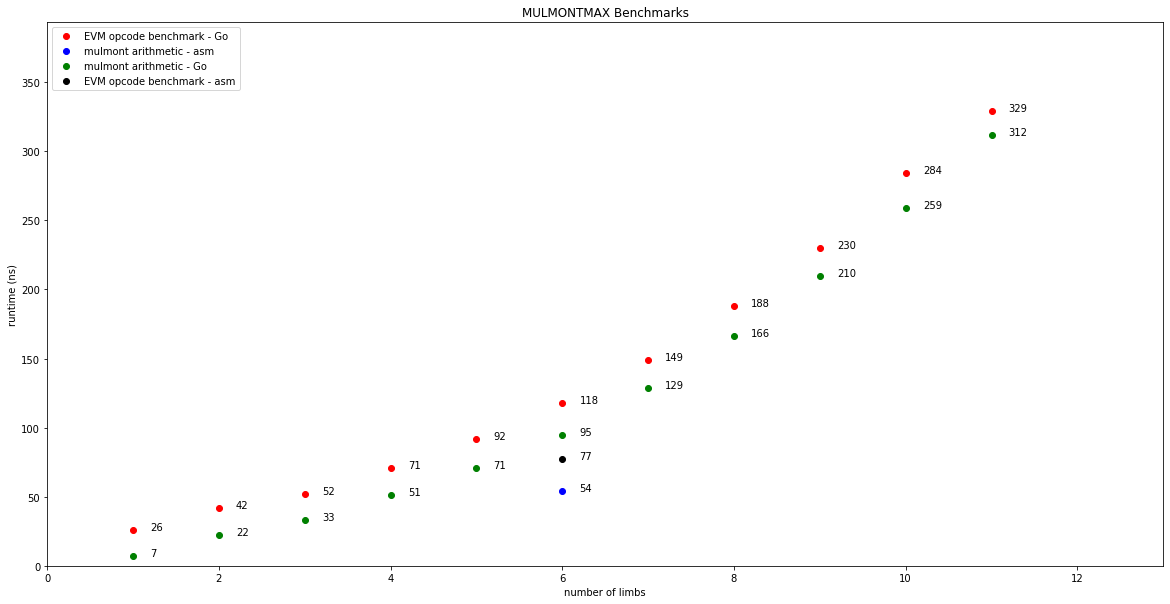

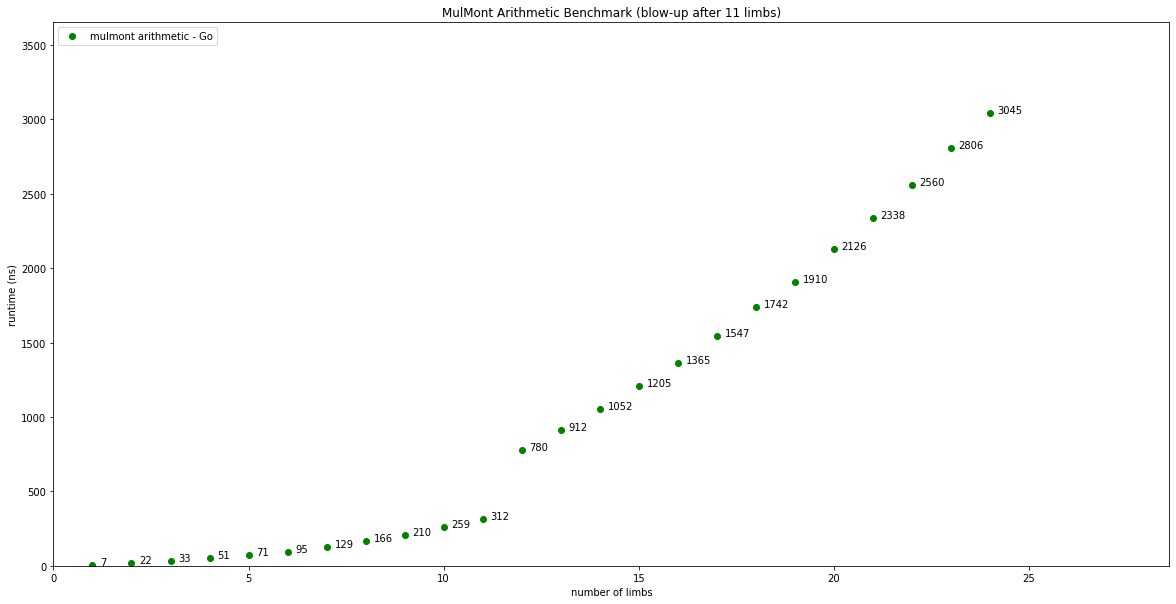

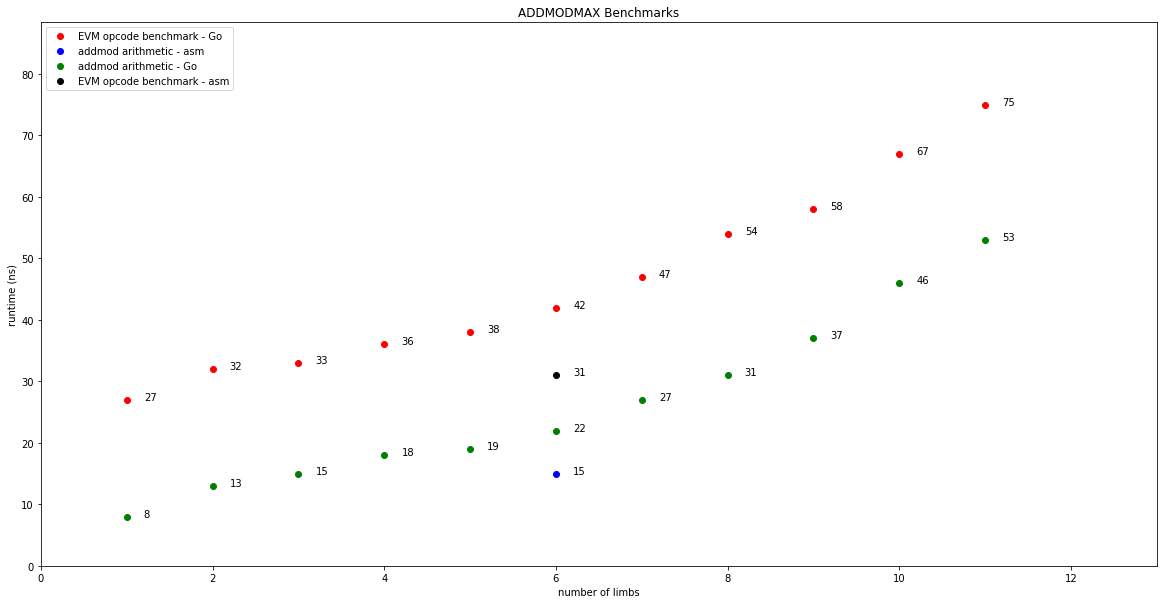

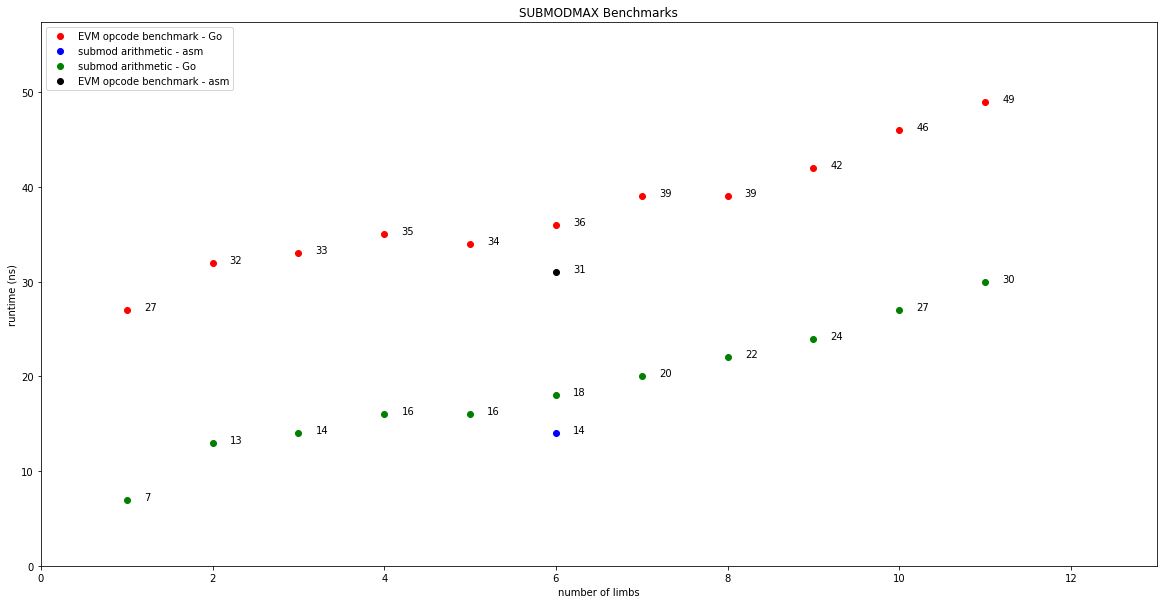

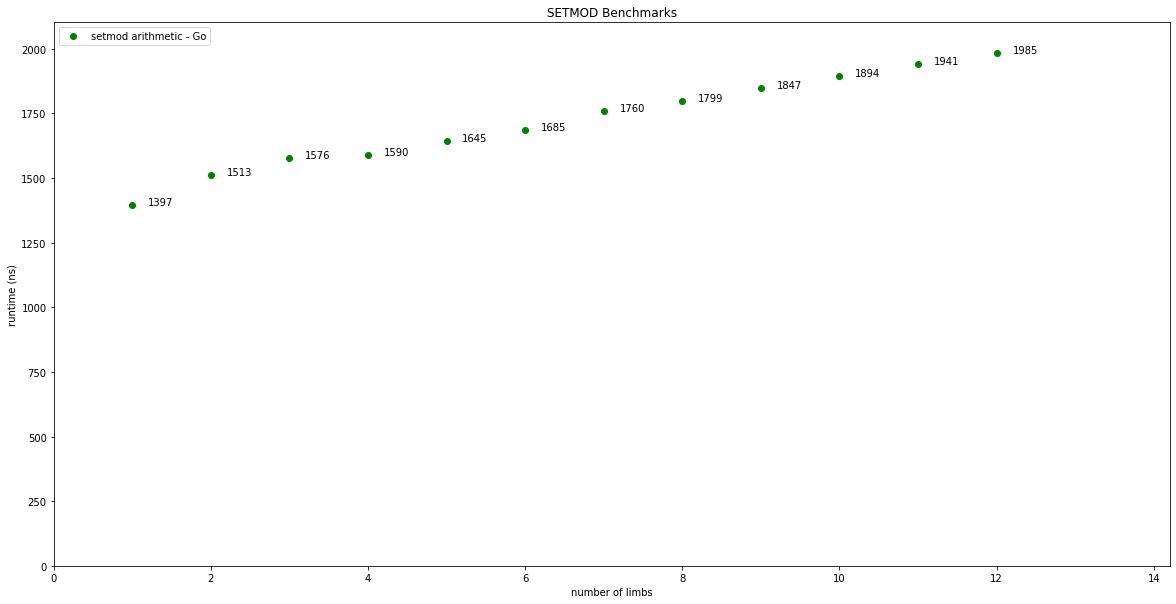

In [10]:
scatterplot_ns_data("MULMONTMAX Benchmarks", True, (geth_evm_go_benchmarks['MULMONTMAX'][:11], "red", "EVM opcode benchmark - Go" ),
                                                    (go_arith_benchmarks['MulMontAsm'], "blue", "mulmont arithmetic - asm"),
                                                    (go_arith_benchmarks['MulMontGo'][:11], "green", "mulmont arithmetic - Go"),
                                                    (geth_evm_asm384_benchmarks['MULMONTMAX'], "black", "EVM opcode benchmark - asm"))

scatterplot_ns_data("MulMont Arithmetic Benchmark (blow-up after 11 limbs)", True, (go_arith_benchmarks['MulMontGo'], "green", "mulmont arithmetic - Go"))

scatterplot_ns_data("ADDMODMAX Benchmarks", True, (geth_evm_go_benchmarks['ADDMODMAX'][:11], "red", "EVM opcode benchmark - Go" ),
                                                    (go_arith_benchmarks['AddModAsm'], "blue", "addmod arithmetic - asm"),
                                                    (go_arith_benchmarks['AddModGo'][:11], "green", "addmod arithmetic - Go"),
                                                    (geth_evm_asm384_benchmarks['ADDMODMAX'], "black", "EVM opcode benchmark - asm"))

scatterplot_ns_data("SUBMODMAX Benchmarks", True, (geth_evm_go_benchmarks['SUBMODMAX'][:11], "red", "EVM opcode benchmark - Go" ),
                                                    (go_arith_benchmarks['SubModAsm'], "blue", "submod arithmetic - asm"),
                                                    (go_arith_benchmarks['SubModGo'][:11], "green", "submod arithmetic - Go"),
                                                    (geth_evm_asm384_benchmarks['SUBMODMAX'], "black", "EVM opcode benchmark - asm"))

#scatterplot_ns_data("ADDMODMAX Benchmarks", True, (geth_evm_evmmax_benchmarks['ADDMODMAX'][:-1], "red", "opcode benchmark - Go" ),
#                                                    (go_arith_evmmax_benchmarks['AddMod'][:-2], "green", "mulmont only - Go"),
#                                                    (go_arith_asm384_benchmarks['AddMod'], "blue", "mulmont only - asm"),
#                                                    (geth_evm_asm384_benchmarks['ADDMODMAX'], "black", "opcode benchmark - asm"))

#scatterplot_ns_data("SUBMODMAX Benchmarks", True, (geth_evm_evmmax_benchmarks['SUBMODMAX'][:-1], "red", "opcode benchmark - Go" ),
#                                                    (go_arith_evmmax_benchmarks['SubMod'][:-2], "green", "mulmont only - Go"),
#                                                    (go_arith_asm384_benchmarks['SubMod'], "blue", "mulmont only - asm"),
#                                                    (geth_evm_asm384_benchmarks['SUBMODMAX'], "black", "opcode benchmark - asm"))

scatterplot_ns_data("SETMOD Benchmarks", True, (go_arith_benchmarks['SetMod'], "green", "setmod arithmetic - Go"))


#### Python Arithmetic Implementation


```
import math

MAX_LIMB_COUNT = 12
LIMB_BITS = 64
WORD_SIZE = 8
LIMB_SIZE = 8
BASE = 1 << 64

# -----------------------------------------------------------------------------
#   start of bignum util code and other helpers
#   numbers are expressed as little-endian lists 64bit unsigned integers

# return x - y (omitting borrow-out)
def limbs_sub(x: [int], y: [int]) -> [int]:
    assert len(x) == len(y), "num_limbs must be equal"
    num_limbs = len(x)
    res = [0] * num_limbs
    c = 0

    for i in range(num_limbs):
        c, res[i] = sub_with_borrow(x[i], y[i], c)

    return res[:]

# given two equally-sized, multiple-limb numbers x, y: return x >= y
def limbs_gte(x, y) -> bool:
    assert len(x) == len(y), "x and y should have same number of limbs"
    
    for (x_limb, y_limb) in reversed(list(zip(x,y))):
        if x_limb > y_limb:
            return True
        elif x_limb < y_limb:
            return False

    return True

# convert an int to a bigint, padding with zero-limbs if limb_count is specified
# and num wouldn't occupy limb_count limbs
def int_to_limbs(num: int, limb_count=None) -> [int]:
    res = []

    if limb_count != None:
        assert num < (1 << (limb_count * LIMB_BITS)), "num must be representable with given limb_count"
        for _ in range(limb_count):
            res.append(num % BASE)
            num //= BASE
    else:
        if num == 0:
            return [0]

        while num != 0:
            if num < BASE:
                res.append(num)
                break

            res.append(num % BASE)
            num //= BASE

    return res

def limbs_to_int(limbs: [int]) -> [int]:
    res = 0
    for i, limb in enumerate(limbs):
        res += limb * (BASE ** i)
    return res

# split a 128bit val into hi/low words
def hi_lo(val128: int) -> (int, int):
    assert val128 < 1 << (LIMB_BITS * 2), "val must fit in two words"
    return (val128 >> LIMB_BITS) % BASE, val128 % BASE

# compute (x - y - b). if negative 1, (x - y - b) % BASE, else return 0, (x - y - b) % BASE
# b (borrow-in) must be 1 or 0
def sub_with_borrow(x: int, y: int, b: int) -> (int, int):
    assert b == 0 or b == 1, "borrow in must be zero or one"

    res = x - y - b
    b_out = 0
    if res < 0:
        res = BASE - abs(res)
        b_out = 1

    return b_out, res

# -----------------------------------------------------------------------------
# start of EVMMAX arithmetic

# implementation adapted from section 2.3.2 in https://www.microsoft.com/en-us/research/wp-content/uploads/1998/06/97Acar.pdf
# mulmont_cios computes (x * y * pow(R, -1, mod)) % mod, where R = 1 << (limb_count * word_size * 8)
# modinv must be pow(-mod, -1, BASE)
def mulmont_cios(x, y, mod, modinv) -> [int]:
    assert len(x) == len(y) and len(y) == len(mod), "{}, {}, {}".format(x, y, mod)
    assert mod[-1] != 0, "modulus must occupy all limbs"

    limb_count = len(mod)

    t = [0] * (limb_count + 2)

    for i in range(limb_count):
        # first inner-loop multiply x * y[i]
        c = 0 
        for j in range(limb_count):
            c, t[j] = hi_lo(t[j] + x[j] * y[i] + c)

        t[limb_count + 1], t[limb_count] = hi_lo(t[limb_count] + c)

        m = (modinv * t[0]) % BASE
        c, _ = hi_lo(m * mod[0] + t[0])

        # second inner-loop: reduction.
        for j in range(1, limb_count):
            c, t[j - 1] = hi_lo(t[j] + mod[j] * m + c)

        hi, t[limb_count - 1] = hi_lo(t[limb_count] + c)
        t[limb_count] = t[limb_count + 1] + hi

    t = t[:-1]
    if t[-1] != 0:
        return limbs_sub(t, mod + [0])[:-1]
    elif limbs_gte(t[:-1], mod):
        return limbs_sub(t[:-1], mod)
    else:
        return t[:-1]


# addmod computes (x + y) % mod
def addmod(x: [int], y: [int], mod: [int]) -> [int]:
    assert len(x) == len(y) and len(y) == len(mod), "bignum inputs must have same length"
    limb_count = len(mod)
    tmp = [0] * limb_count
    z = [0] * limb_count
    c, c1 = 0, 0

    if limbs_gte(x, mod) or limbs_gte(y, mod):
        raise Exception("x/y must be less than the modulus")

    for i in range(limb_count):
        c, tmp[i] = hi_lo(x[i] + y[i] + c)

    for i in range(limb_count):
        c1, z[i] = sub_with_borrow(tmp[i], mod[i], c1)

    if c == 0 and c1 != 0:
        z[:] = tmp[:]

    return z

# submod computes (x - y) % mod
def submod(x: [int], y: [int], mod: [int]) -> [int]:
    assert len(x) == len(y) and len(y) == len(mod), "bignum inputs must have same length"
    limb_count = len(mod)
    tmp = [0] * limb_count
    z = [0] * limb_count
    c, c1 = 0, 0

    if limbs_gte(x, mod) or limbs_gte(y, mod):
        raise Exception("x/y must be less than the modulus")

    for i in range(limb_count):
        c, tmp[i] = sub_with_borrow(x[i], y[i], c)

    for i in range(limb_count):
        c1, z[i] = hi_lo(tmp[i] + mod[i] + c1)

    if c == 0:
        z[:] = tmp[:]

    return z

# setmod computes a modulus-specific constant used by the CIOS algorithm (and also some other algorithms that operate at small bit-widths)
def setmod(mod: [int]) -> int:
    assert len(mod) > 0 and len(mod) <= MAX_LIMB_COUNT, "modulus must be in correct range"
    result = pow(-limbs_to_int(mod), -1, BASE)
    return result
```

## Backwards Compatibility

There are no backwards-compatibility concerns for the changes introduced in this EIP.

## Test Cases
TODO

## Reference Implementation

Geth implementation: https://github.com/jwasinger/go-ethereum/tree/evmmax-no-eof

Arithmetic reference implementation written in Python: https://github.com/jwasinger/py-evmmax

## Security Considerations
* TODO